In [1]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
import re

from utils import get_env, wrap_recording, image_to_base64, numpy_to_base64,load_demonstrations

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [3]:
# from google import genai
# client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

In [4]:
from anthropic import Anthropic

client = Anthropic(api_key=os.environ.get("CLAUDE_API_KEY"))

In [5]:
# from openai import OpenAI

# client = OpenAI(
#     api_key=os.getenv("DASHSCOPE_API_KEY"),
#     base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
# )

In [6]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [7]:
# from transformers import AutoProcessor, AutoModelForImageTextToText
# import torch

# smolvlm2_model_path = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
# smolvlm2_processor = AutoProcessor.from_pretrained(smolvlm2_model_path)
# smolvlm2_model = AutoModelForImageTextToText.from_pretrained(
#     smolvlm2_model_path,
#     torch_dtype=torch.bfloat16,
#     _attn_implementation="flash_attention_2"
# ).to("cuda")

In [8]:
def call_smolvlm2(prompt, step, actions):
    content = []
    for s in range(step-2, step+1):
        content.append({"type": "text", "text": f'Step {s}: action: {index_to_action(actions[s][0])} reward {actions[s][1]}'})
        content.append({"type": "image", "url": f'data:image/png;base64,{image_to_base64(f"states/{s}.png")}'})
    content.append({"type": "text", "text": prompt})

    messages = [{
        "role": "user",
        "content": content
    }]

    inputs = smolvlm2_processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(smolvlm2_model.device, dtype=torch.bfloat16)

    generated_ids = smolvlm2_model.generate(**inputs, do_sample=False, max_new_tokens=64)
    generated_texts = smolvlm2_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    res = generated_texts[0]
    print(res)

    match = re.search("<action>(.+)</action>", res)
    if match:
        return match[1]
    else:
        return "NOOP"

In [9]:
def call_gemini(prompt, step, actions, use_expert_demo=False):
    contents = []
    contents.append(f'Expert demonstrations:')
    if use_expert_demo:
        contents.append(Image.fromarray(demonstrations[0][0]))
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations[:50]):
            contents.append(f'Step {i}: action {index_to_action(action)} reward {reward}')
            contents.append(Image.fromarray(next_state))
    contents.append(f'Your previous 4 steps:')
    for s in range(step-2, step+1):
        contents.append(f'Step {s}: action {index_to_action(actions[s][0])} reward {actions[s][1]}')
        contents.append(Image.open(f'states/{s}.png'))
    contents.append(prompt)
    
    print(contents)

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=contents,
        config = {
            'response_mime_type': 'application/json',
            'response_schema': { "type": "OBJECT",
                "properties": {
                    "reasoning": { "type": "STRING", "description": "Step by step reasoning on which action to perform" },
                    "action": { "type": "STRING", "enum": ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"], "description": "Next action to perform" }
                },
                "required": ["reasoning", "action"],
                "propertyOrdering": ["reasoning", "action"]
            }
        }
    )
    response = json.loads(response.text)
    print(response['action'] + ' ' + response['reasoning'])
    return response['action']

In [10]:
def call_claude(prompt, step, actions, frames, demonstrations, resize_to):
    MODEL_NAME = "claude-3-7-sonnet-20250219"
    contents = []
    if len(demonstrations) > 0:
        contents.append({"type": "text", "text": f'Expert demonstrations:'})
        contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(demonstrations[0][0], resize_to=resize_to)}})
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations):
            contents.append({"type": "text", "text": f'Step {i}: action {index_to_action(action)} reward {reward}'})
            contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(next_state, resize_to=resize_to)}})
        contents.append({"type": "text", "text": f'Your previous 4 steps:'})
    
    buffer = np.array(frames[step])
    for s in range(step, step+1):
        contents.append({"type": "text", "text": f'Step {s}: action {index_to_action(actions[s][0])} reward {actions[s][1]}'})
        contents.append({"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": numpy_to_base64(buffer[s - step - 1], resize_to=resize_to)}})
    contents.append({"type": "text", "text": prompt})

    message_list = [
        {
            "role": 'user',
            "content": contents
        }
    ]
    
    for c in contents:
        if c['type'] == 'text':
            print(c['text'])
        elif c['type'] == 'image':
            import base64
            import io
            from matplotlib import pyplot as plt
            import matplotlib.image as mpimg
            i = base64.b64decode(c['source']['data'].removeprefix('data:image/png;base64,'))
            i = io.BytesIO(i)
            i = mpimg.imread(i, format='PNG')
            plt.figure()
            plt.imshow(i, interpolation='nearest')
            plt.show()

    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=500,
        messages=message_list
    )
    print(response.content[0].text)
    res = re.findall('```json(.+)```', response.content[0].text, re.DOTALL)
    if res:
        res = res[0]
    print(res)
    res = json.loads(res)
    return res['action']


In [13]:
def call_openai(prompt, step, actions, frames, demonstrations, resize_to):
    content = []

    if len(demonstrations) > 0:
        content.append({"type": "text", "text": f'Expert demonstrations:'})
        content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(demonstrations[0][0], resize_to=resize_to)}'}})
        for i, (state, action, reward, next_state, done) in enumerate(demonstrations):
            content.append({"type": "text", "text": f'Step {i}: action {index_to_action(action)} reward {reward}'})
            content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(next_state, resize_to=resize_to)}'}})

    buffer = np.array(frames[step])
    for s in range(step, step+1):
        content.append({"type": "text", "text": f'Step: {s} action: {index_to_action(actions[s][0])} reward: {actions[s][1]}'})
        content.append({"type": "image_url", "image_url": {"url": f'data:image/png;base64,{numpy_to_base64(buffer[s - step - 1], resize_to=resize_to)}'}})
    content.append({"type": "text", "text": prompt})

    for c in content:
        if c['type'] == 'text':
            print(c['text'])
        elif c['type'] == 'image_url':
            import base64
            import io
            from matplotlib import pyplot as plt
            import matplotlib.image as mpimg
            i = base64.b64decode(c['image_url']['url'].removeprefix('data:image/png;base64,'))
            i = io.BytesIO(i)
            i = mpimg.imread(i, format='PNG')
            plt.figure()
            plt.imshow(i, interpolation='nearest')
            plt.show()

    message_list = [
        {
            "role": 'user',
            "content": content
        }
    ]
    completion = client.chat.completions.create(
        # model='gpt-4o-2024-11-20',
        model='o1-2024-12-17',
        messages=message_list,
        response_format={ "type": "json_schema", "json_schema": {
            "name": "pick_next_action",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": {
                    "game_state": { "type": "string" },
                    "reasoning": { "type": "string" },
                    "action": {
                        "type": "string",
                        "description": "next action",
                        "enum": ["NOOP", "UP", "RIGHT", "LEFT", "DOWN"]
                    }
                },
                "additionalProperties": False,
                "required": ["game_state", "reasoning", "action"]
            }
        }}
    )
    res = completion.choices[0].message.content
    print(res)
    return json.loads(res)['action']


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /teamspace/studios/this_studio/gpt4o folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Step: 108 action: NOOP reward: 0


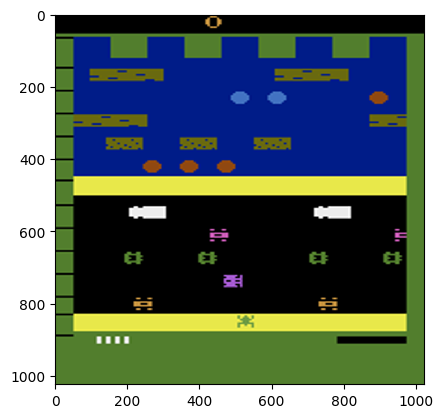

You are a game playing assistant and will be provided an image. Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think about all possible actions and why each action is or is not the best action to take. I'm at step 108 and the potential actions I can take are NOOP, UP, RIGHT, LEFT, DOWN.
Provide output as a json structured as game_state: describe the current game state in detail, including the position of the player and its surroundings, reasoning: reasoning for actions and why to choose an action, action: The environment action which would provide the best next state.
{
  "game_state": "Frog is currently at the bottom row of the screen. Several cars are moving across the black road lanes above, including a pink car near the center and white cars further left and right. Above the road, logs and turtles are moving along the water.",
  "reasoning": "The frog’s goal is to cross safely. The nearest vehicle rows don’t appear to have a ve

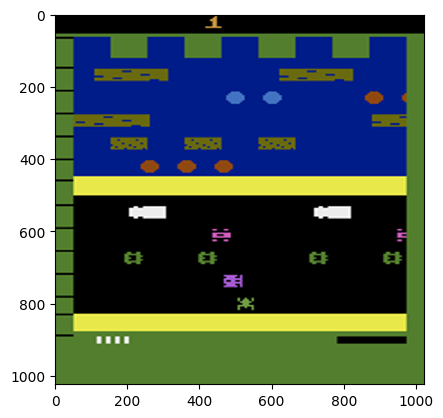

You are a game playing assistant and will be provided an image. Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think about all possible actions and why each action is or is not the best action to take. I'm at step 109 and the potential actions I can take are NOOP, UP, RIGHT, LEFT, DOWN.
Provide output as a json structured as game_state: describe the current game state in detail, including the position of the player and its surroundings, reasoning: reasoning for actions and why to choose an action, action: The environment action which would provide the best next state.
{
  "game_state": "The frog is partway across the bottom traffic lanes, with cars in adjacent lanes moving horizontally. There is a white car moving above the frog’s lane and a pink car off to the right, but the path directly above the frog appears open. The next water area and logs are above the traffic lanes.",
  "reasoning": "The frog has just successfully moved up

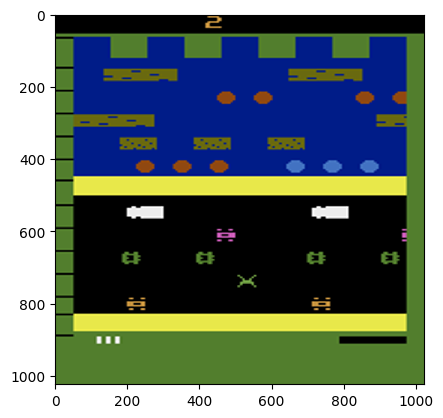

You are a game playing assistant and will be provided an image. Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think about all possible actions and why each action is or is not the best action to take. I'm at step 110 and the potential actions I can take are NOOP, UP, RIGHT, LEFT, DOWN.
Provide output as a json structured as game_state: describe the current game state in detail, including the position of the player and its surroundings, reasoning: reasoning for actions and why to choose an action, action: The environment action which would provide the best next state.


KeyboardInterrupt: 

In [14]:
import json
import enum

process_images = False
resize_to = (1024, 1024)
env = get_env(process=process_images)
wrap_recording(env, video_folder='gpt4o', episode_trigger=lambda x: True, name_prefix='zeroshot')

state, info = env.reset()

max_steps = 1000
actions_dict = { "NOOP": 0, "UP": 1, "RIGHT": 2, "LEFT": 3, "DOWN": 4 }

def action_to_index(action: str) -> int:
    return actions_dict[action]

def index_to_action(index: int) -> str:
    return list(actions_dict.keys())[index]

state, info = env.reset()
actions = []
frames = []
# demonstrations = load_demonstrations(process=process_images)[10:30]
demonstrations = []

# skip over initial 109 frames (with default frameskip=4) where control is not enabled
for step in range(109):
    state, reward, terminated, truncated, _ = env.step(0)
    actions.append((0, 0))
    frames.append(state)

total_reward = 0
while step < max_steps:
    # with open('frogger_manual.txt', 'r') as f:
    #     prompt = f.read()
    prompt = f"""You are a game playing assistant and will be provided an image. Your goal is to provide me with what you believe to be the best action I could take to beat the game.
Think about all possible actions and why each action is or is not the best action to take. I'm at step {step} and the potential actions I can take are NOOP, UP, RIGHT, LEFT, DOWN.
Provide output as a json structured as game_state: describe the current game state in detail, including the position of the player and its surroundings, reasoning: reasoning for actions and why to choose an action, action: The environment action which would provide the best next state."""

    action = call_openai(prompt, step, actions, frames, demonstrations, resize_to)
    action = action_to_index(action)

    with open('actions.json', 'w+') as f:
        f.write(json.dumps(actions))
    print(f'Step {step} action: {action} total reward: {total_reward}')

    state, reward, terminated, truncated, _ = env.step(action)
    actions.append((action, reward))
    frames.append(state)
    total_reward += reward
    step += 1

    if terminated or truncated:
        print('GAME ENDED')
        break

    state, reward, terminated, truncated, _ = env.step(0)
    total_reward += reward

env.close()
print(f'Total reward: {total_reward}')